In [ ]:
!pip install qiskit
!pip install qiskit-machine-learning
!pip install qiskit.Utils
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 17.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
data = pd.read_csv('/content/seeds.csv')

In [ ]:
print(data)

      Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0    15.26      14.84       0.8710          5.763         3.312   
1    14.88      14.57       0.8811          5.554         3.333   
2    14.29      14.09       0.9050          5.291         3.337   
3    13.84      13.94       0.8955          5.324         3.379   
4    16.14      14.99       0.9034          5.658         3.562   
..     ...        ...          ...            ...           ...   
194  12.19      13.20       0.8783          5.137         2.981   
195  11.23      12.88       0.8511          5.140         2.795   
196  13.20      13.66       0.8883          5.236         3.232   
197  11.84      13.21       0.8521          5.175         2.836   
198  12.30      13.34       0.8684          5.243         2.974   

     Asymmetry.Coeff  Kernel.Groove  Type  
0              2.221          5.220     1  
1              1.018          4.956     1  
2              2.699          4.825     1  
3              2.25

In [ ]:
features = data.drop('Type',axis = 1).values
labels = data['Type'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [ ]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(train_features, train_labels)  # suppress printing the return value

In [ ]:
train_score = svc.score(train_features, train_labels)
test_score = svc.score(test_features, test_labels)

print(f"Classical SVC on the training dataset: {train_score:.4f}")
print(f"Classical SVC on the test dataset:     {test_score:.2f}")

Classical SVC on the training dataset: 0.9560
Classical SVC on the test dataset:     0.95


In [ ]:
from qiskit.circuit.library import ZZFeatureMap
from pylatexenc import *

num_features = features.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
#feature_map.decompose().draw(output="mpl", fold=20)

In [ ]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
#ansatz.decompose().draw(output="mpl", fold=20)

In [ ]:
from qiskit.algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

In [ ]:
from qiskit.primitives import Sampler

sampler = Sampler()

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

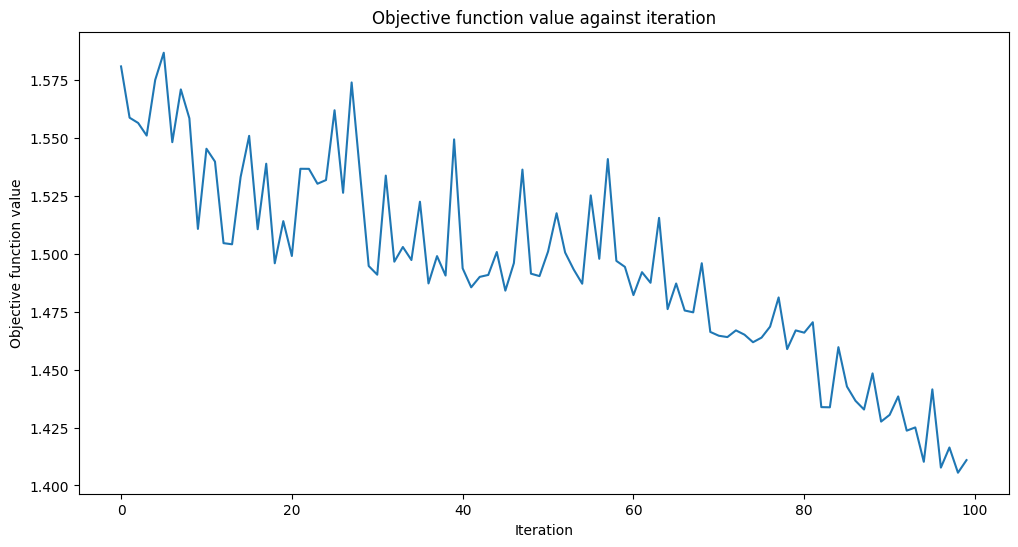

In [ ]:
#import time
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

#start = time.time()
vqc.fit(train_features, train_labels)
#elapsed = time.time() - start

#print(f"Training time: {round(elapsed)} seconds")

In [ ]:
train_score_q4 = vqc.score(train_features, train_labels)


print(f"Quantum VQC on the training dataset: {train_score_q4:.4f}")


Quantum VQC on the training dataset: 0.7358


In [ ]:
# Generate predictions on the test dataset
test_predictions = vqc.predict(test_features)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(test_labels, test_predictions, average='weighted')
recall = recall_score(test_labels, test_predictions, average='weighted')
f1 = f1_score(test_labels, test_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.7523660714285715
Recall: 0.7
F1-score: 0.7157029926595145


#end of code

In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 12.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:
dataset = pd.read_csv('supermarket_sales - Sheet1.csv')
dataset = dataset.dropna()
dataset

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[["Unit price","Quantity","Total","cogs","gross margin percentage","gross income","Rating"]] = scaler.fit_transform(dataset[["Unit price","Quantity","Total","cogs","gross margin percentage","gross income","Rating"]])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = dataset[["Unit price","Quantity","Total","cogs","gross margin percentage","gross income","Rating"]].values
y = dataset["Gender"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
vqc = VQC(
    num_qubits=7,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
)

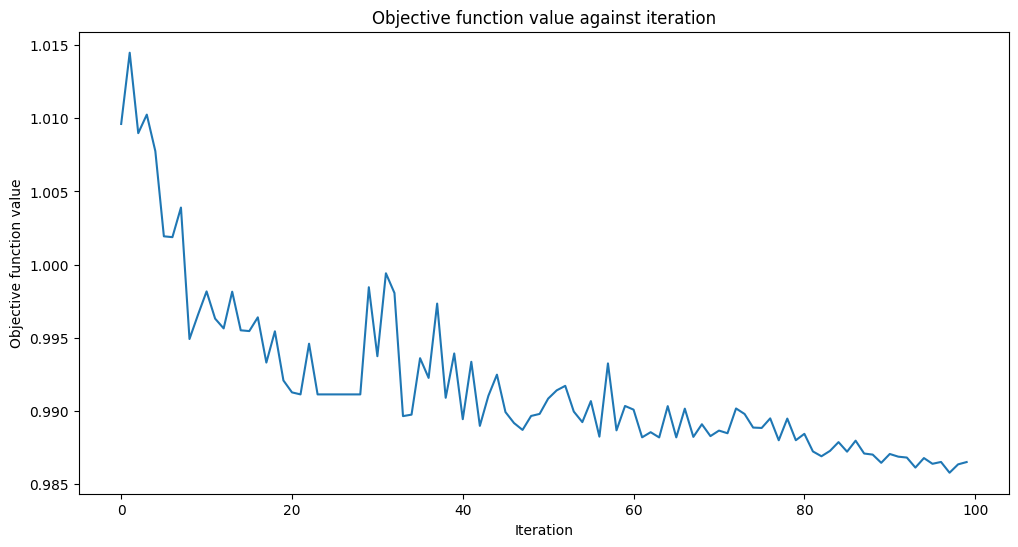

0.54625

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train, y_train)

In [ ]:
# score classifier
print(f"Accuracy from the train data : {np.round(100 * vqc.score(X_train, y_train), 2)}%")

In [ ]:
# Generate predictions on the test dataset
test_predictions = vqc.predict(X_train)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, test_predictions, average='weighted')
recall = recall_score(y_train, test_predictions, average='weighted')
f1 = f1_score(y_train, test_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5462587970949273
Recall: 0.54625
F1-score: 0.546253545060354


#end of code

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:
dataset = pd.read_csv('Breast_cancer_data.csv')
dataset = dataset.dropna()
dataset

In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness"]] = scaler.fit_transform(dataset[["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness"]])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = dataset[["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness"]].values
y = dataset["diagnosis"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
vqc = VQC(
    num_qubits=5,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
)

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train, y_train)

In [ ]:
print(f"Accuracy from the train data : {np.round(100 * vqc.score(X_train, y_train), 2)}%")

In [ ]:
# Generate predictions on the test dataset
test_predictions = vqc.predict(X_train)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, test_predictions, average='weighted')
recall = recall_score(y_train, test_predictions, average='weighted')
f1 = f1_score(y_train, test_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5987841290362299
Recall: 0.6241758241758242
F1-score: 0.5945813785817498


#end of code

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:
dataset = pd.read_csv('Iris.csv')
dataset = dataset.dropna()
dataset

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[["Id","SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]] = scaler.fit_transform(dataset[["Id","SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = dataset[["Id","SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]].values
y = dataset["Species"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
vqc = VQC(
    num_qubits=5,
    optimizer=COBYLA(maxiter=100),
    callback=callback_graph,
)

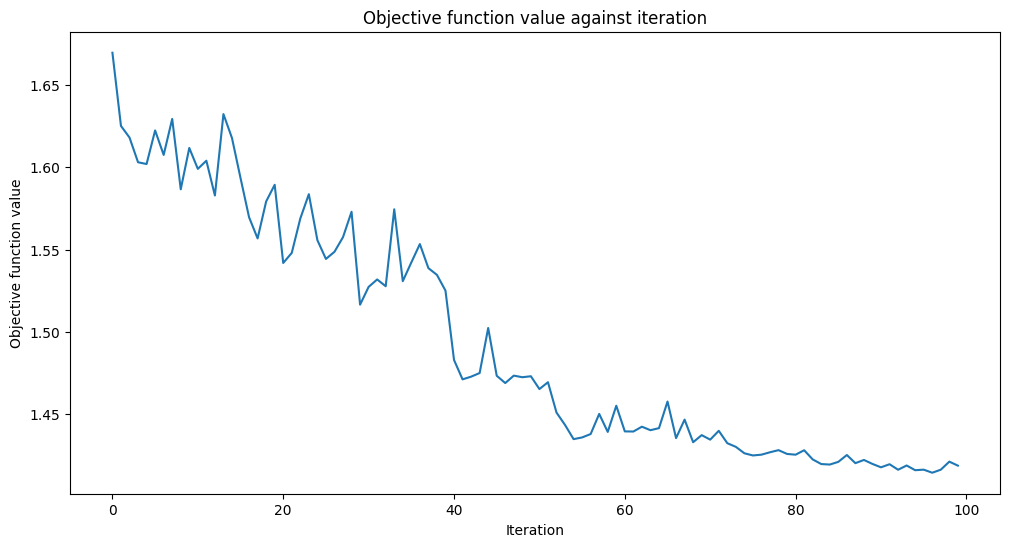

0.575

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train, y_train)

In [ ]:
print(f"Accuracy from the train data : {np.round(100 * vqc.score(X_train, y_train), 2)}%")

Accuracy from the train data : 57.5%


In [ ]:
# Generate predictions on the test dataset
test_predictions = vqc.predict(X_train)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, test_predictions, average='weighted')
recall = recall_score(y_train, test_predictions, average='weighted')
f1 = f1_score(y_train, test_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5767300101858925
Recall: 0.575
F1-score: 0.5702026358285149
